In [62]:
import h5py
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [63]:
#load the data
with h5py.File('data/background_for_training.h5', 'r') as f:
    X = f['Particles'][:100000]  #will load more if this works

In [64]:
# Flatten (particles, features) → 1D per event
X = X.reshape(X.shape[0], -1)
X = np.nan_to_num(X)  # remove any NaNs

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)
X_tensor = torch.tensor(X_scaled)

In [65]:
#standard vae model class
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * latent_dim)  # mu and logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar, z


In [66]:
#get the distance correlation given and x and y var
def distance_correlation(x, y):
    x = x - x.mean(0)
    y = y - y.mean(0)
    a = torch.cdist(x, x)
    b = torch.cdist(y, y)
    A = a - a.mean(0) - a.mean(1, keepdim=True) + a.mean()
    B = b - b.mean(0) - b.mean(1, keepdim=True) + b.mean()
    dcov = (A * B).mean()
    dvar_x = (A * A).mean().sqrt()
    dvar_y = (B * B).mean().sqrt()
    return dcov / (dvar_x * dvar_y + 1e-10)

In [67]:
#calculate loss with mse for vae
def vae_loss(x, x_hat, mu, logvar):
    recon = F.mse_loss(x_hat, x, reduction='mean')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kld

In [68]:
def full_loss(x, out1, out2, lambda_disco=20.0):
    x1_hat, mu1, logvar1, z1 = out1
    x2_hat, mu2, logvar2, z2 = out2
    loss1 = vae_loss(x, x1_hat, mu1, logvar1)
    loss2 = vae_loss(x, x2_hat, mu2, logvar2)
    disco = distance_correlation(z1, z2)
    return loss1 + loss2 + lambda_disco * disco

In [69]:
vae1 = VAE(X_tensor.shape[1])
vae2 = VAE(X_tensor.shape[1])
optimizer = torch.optim.Adam(list(vae1.parameters()) + list(vae2.parameters()), lr=1e-3)

batch_size = 512
for epoch in range(1, 31):
    perm = torch.randperm(X_tensor.size(0))
    total_loss = 0
    for i in range(0, X_tensor.size(0), batch_size):
        xb = X_tensor[perm[i:i+batch_size]]
        out1 = vae1(xb)
        out2 = vae2(xb)
        loss = full_loss(xb, out1, out2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:2d} | Loss: {total_loss:.2f}")


Epoch  1 | Loss: 141616.12
Epoch  2 | Loss: 498.37
Epoch  3 | Loss: 496.42
Epoch  4 | Loss: 494.32
Epoch  5 | Loss: 494.42
Epoch  6 | Loss: 494.11
Epoch  7 | Loss: 507.52
Epoch  8 | Loss: 489.56
Epoch  9 | Loss: 485.03
Epoch 10 | Loss: 485.58
Epoch 11 | Loss: 481.42
Epoch 12 | Loss: 482.09
Epoch 13 | Loss: 482.01
Epoch 14 | Loss: 481.64
Epoch 15 | Loss: 479.92
Epoch 16 | Loss: 478.62
Epoch 17 | Loss: 478.81
Epoch 18 | Loss: 475.53
Epoch 19 | Loss: 473.86
Epoch 20 | Loss: 473.68
Epoch 21 | Loss: 473.05
Epoch 22 | Loss: 469.46
Epoch 23 | Loss: 476.23
Epoch 24 | Loss: 472.48
Epoch 25 | Loss: 469.75
Epoch 26 | Loss: 469.13
Epoch 27 | Loss: 467.62
Epoch 28 | Loss: 469.55
Epoch 29 | Loss: 475.02
Epoch 30 | Loss: 467.19


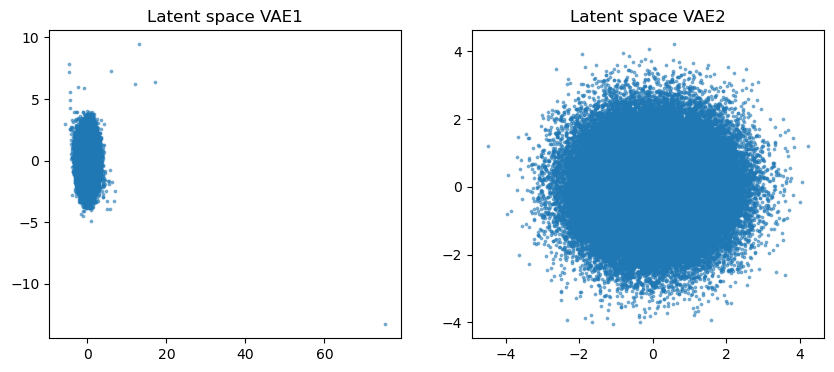

In [72]:
with torch.no_grad():
    z1 = vae1(X_tensor)[-1].numpy()
    z2 = vae2(X_tensor)[-1].numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(z1[:,0], z1[:,1], s=3, alpha=0.5)
plt.title("Latent space VAE1")

plt.subplot(1,2,2)
plt.scatter(z2[:,0], z2[:,1], s=3, alpha=0.5)
plt.title("Latent space VAE2")
plt.show()

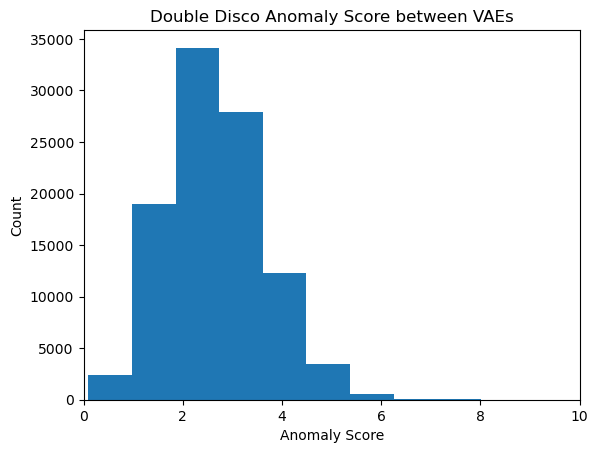

In [73]:
anomaly_score = np.linalg.norm(z1 - z2, axis=1)
plt.hist(anomaly_score, bins=100)
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.title("Double Disco Anomaly Score between VAEs")
plt.xlim(0,10)
plt.show()